#### Data
- All A shares. Remove stocks of ST, *ST, delisted, and Less than three months on the market.
- Daily indexes include: OPEN, HIGH, LOW, CLOSE, VWAP, and VOLUME.

#### Models
- MLP
- GBDT
- GRU
- AGRU

In [28]:
from cylib.apis.all_api import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress the warning
# warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

zscore = StandardScaler()

### Remove inappropriate stocks.

In [29]:
# Remove inappropriate stocks.
all_stocks = get_targets_info(target_type='stock')
all_stocks = all_stocks[["ts_code", "name", "list_date", "list_board_name"]]
all_stocks = all_stocks.dropna()
all_stocks['list_date'] = pd.to_datetime(all_stocks['list_date']) 
all_stocks = all_stocks[all_stocks['list_date'] <= pd.to_datetime('2011-07-01')] # Remove stocks before 2011-07-01.
all_stocks = all_stocks[all_stocks['ts_code'].str[0] != 'A'] # Remove unlisted stocks.
all_stocks= all_stocks[all_stocks['list_board_name'] != '北证']
all_stocks = all_stocks[~all_stocks['name'].str.endswith("(IPO终止)")]
all_stocks = all_stocks[~all_stocks['name'].str.endswith("(退市)")] # Remove delisted stocks.
all_stocks = all_stocks[~all_stocks['name'].str.startswith('ST')] # Remove ST
all_stocks = all_stocks[~all_stocks['name'].str.startswith('*ST')] # Remove *ST

# Remove '000792.SZ' and '000670.SZ' as they have missing values.
mask = all_stocks['ts_code'].isin(['000792.SZ', '000670.SZ'])
new_df = all_stocks[mask]

# removing the filtered rows from the original dataframe
all_stocks = all_stocks[~mask]

stocks_code = list(all_stocks['ts_code'])
stocks_code

['600000.SH',
 '600004.SH',
 '600006.SH',
 '600007.SH',
 '600008.SH',
 '600009.SH',
 '600010.SH',
 '600011.SH',
 '600012.SH',
 '600015.SH',
 '600016.SH',
 '600017.SH',
 '600018.SH',
 '600019.SH',
 '600020.SH',
 '600021.SH',
 '600022.SH',
 '600026.SH',
 '600027.SH',
 '600028.SH',
 '600029.SH',
 '600030.SH',
 '600031.SH',
 '600033.SH',
 '600035.SH',
 '600036.SH',
 '600037.SH',
 '600038.SH',
 '600039.SH',
 '600048.SH',
 '600050.SH',
 '600051.SH',
 '600052.SH',
 '600053.SH',
 '600054.SH',
 '600055.SH',
 '600056.SH',
 '600057.SH',
 '600058.SH',
 '600059.SH',
 '600060.SH',
 '600061.SH',
 '600062.SH',
 '600063.SH',
 '600064.SH',
 '600066.SH',
 '600067.SH',
 '600071.SH',
 '600072.SH',
 '600073.SH',
 '600075.SH',
 '600076.SH',
 '600079.SH',
 '600080.SH',
 '600081.SH',
 '600082.SH',
 '600083.SH',
 '600084.SH',
 '600085.SH',
 '600088.SH',
 '600089.SH',
 '600094.SH',
 '600095.SH',
 '600096.SH',
 '600097.SH',
 '600098.SH',
 '600099.SH',
 '600100.SH',
 '600101.SH',
 '600103.SH',
 '600104.SH',
 '6001

### Get stocks

In [30]:
# Get stocks

begin_date = '20210101'
end_date = '20240225'
price = get_price(
    ts_code_list=stocks_code,
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "avg_price",
        "volume",
        "trade_status", # "交易"/"停牌"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="stock",
)
price = price.rename(columns={'open': 'OPEN',
                              'high': 'HIGH',
                              'low': 'LOW',
                              'close': 'CLOSE',
                              'avg_price': 'VWAP',
                              'volume': 'VOLUME'})
price.reset_index(inplace=True)
indexes = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VWAP', 'VOLUME']
# Add weekend, If it is Monday, the value is 1, or 0.
# price['Monday'] = (price['trade_date'].dt.dayofweek == 0).astype(int)
price = price.sort_values(by='trade_date').reset_index(drop=True)
# price.set_index(['trade_date', 'ts_code'], inplace=True)
price.fillna(0, inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status
0,2021-01-04,000001.SZ,19.10,19.10,18.44,18.60,18.6054,1554220.0,交易
1,2021-01-04,002496.SZ,2.57,2.59,2.53,2.59,2.5841,92935.8,交易
2,2021-01-04,600282.SH,3.12,3.16,3.10,3.13,3.1226,402884.0,交易
3,2021-01-04,600973.SH,4.36,4.52,4.35,4.46,4.4587,143660.0,交易
4,2021-01-04,000972.SZ,2.28,2.39,2.26,2.29,2.3342,21704.0,交易
...,...,...,...,...,...,...,...,...,...
1509355,2024-02-23,600210.SH,4.70,4.72,4.61,4.71,4.6741,154395.0,交易
1509356,2024-02-23,600211.SH,45.20,45.20,44.31,44.88,44.7342,25353.4,交易
1509357,2024-02-23,600212.SH,5.85,5.97,5.82,5.89,5.8855,84547.0,交易
1509358,2024-02-23,600215.SH,7.80,7.99,7.62,7.96,7.7882,63317.5,交易


In [31]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509360 entries, 0 to 1509359
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   trade_date    1509360 non-null  datetime64[ns]
 1   ts_code       1509360 non-null  object        
 2   OPEN          1509360 non-null  float64       
 3   HIGH          1509360 non-null  float64       
 4   LOW           1509360 non-null  float64       
 5   CLOSE         1509360 non-null  float64       
 6   VWAP          1509360 non-null  float64       
 7   VOLUME        1509360 non-null  float64       
 8   trade_status  1509360 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 103.6+ MB


To remove rows from a dataframe based on a condition where the first character of a string column is 'A', you can use the `str.startswith()` method in Pandas. Here's an example:

```python
import pandas as pd

# Create a dataframe
data = {'Column1': ['Apple', 'Banana', 'Orange', 'Apricot', 'Grape']}
df = pd.DataFrame(data)

# Remove rows where 'Column1' starts with 'A'
df = df[~df['Column1'].str.startswith('A')]

# Print the updated dataframe
print(df)
```

In this example, we have a dataframe with one column 'Column1' that contains fruit names as strings. We want to remove rows where the first character of the fruit name is 'A'.

The `str.startswith()` method returns a boolean series that indicates `True` for rows where the string in 'Column1' starts with 'A' and `False` otherwise. By using the tilde operator `~`, we invert the boolean series to get `True` for rows where the string does not start with 'A'.

We then pass this inverted boolean series inside square brackets `df[inverted_boolean_series]` to filter out the rows where the string starts with 'A'.

The resulting dataframe `df` will contain only the rows where the string in 'Column1' does not start with 'A'. You can modify the condition `df['Column1'].str.startswith('A')` based on your specific situation to remove items from the column accordingly.

### Get benchmark index
$ \textcolor{red}{Buy \ at \ today's \ close \ and \ sell \ at \ tomorrow's\ close.\ (Just\ a \ suppose.)} $

In [32]:
# Get benchmark index
# 1. the Shanghai and Shenzhen 300 index(the HS 300 index)(000300)
# 2. the China Securities 500 index(000905)
# 3. the China Securities 1000 index(000852)
benchmark = get_price(
    ts_code_list=["000300.SH", "000905.SH", "000852.SH"],
    feature_list=[
        "open",
        "high",
        "low",
        "close",
        "volume"
    ],
    start_date=begin_date,
    trade_date=end_date,
    target_type="index",
)
benchmark = benchmark.rename(
    columns={
        "open": "OPEN",
        "high": "HIGH",
        "low": "LOW",
        "close": "CLOSE",
        "volume": 'VOLUME'
    }
)
benchmark.reset_index(inplace=True)
# Add weekend, If it is Monday, the value is 1, or 0.
# benchmark["Monday"] = (benchmark["trade_date"].dt.dayofweek == 0).astype(int)
benchmark = benchmark.sort_values(by="trade_date").reset_index(drop=True)
benchmark.fillna(0, inplace=True)
benchmark

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VOLUME
0,2021-01-04,000300.SH,5212.93,5284.43,5190.94,5267.72,211711000.0
1,2021-01-04,000852.SH,6671.93,6809.43,6662.80,6798.76,183205000.0
2,2021-01-04,000905.SH,6395.61,6501.59,6359.08,6482.79,186621000.0
3,2021-01-05,000300.SH,5245.84,5368.50,5234.38,5368.50,224931000.0
4,2021-01-05,000852.SH,6785.52,6827.50,6726.46,6807.45,197248000.0
...,...,...,...,...,...,...,...
2272,2024-02-22,000300.SH,3450.35,3486.68,3448.41,3486.67,141021000.0
2273,2024-02-22,000852.SH,5075.43,5152.02,5066.00,5151.53,153064000.0
2274,2024-02-23,000852.SH,5169.01,5225.67,5114.15,5225.67,171214000.0
2275,2024-02-23,000300.SH,3491.34,3507.56,3472.97,3489.74,144821000.0


### Get daily return DataFrame

In [33]:
BUY_price = price.pivot(index='trade_date', columns='ts_code', values='OPEN')
BUY_benchmark = benchmark.pivot(index='trade_date', columns='ts_code', values='OPEN')
SELL_price = price.pivot(index='trade_date', columns='ts_code', values='CLOSE')
SELL_benchmark = benchmark.pivot(index='trade_date', columns='ts_code', values='CLOSE')
price_return = (SELL_price - BUY_price) / BUY_price
benchmark_return = (SELL_benchmark - BUY_benchmark) / BUY_benchmark

In [34]:
HS_300 = pd.DataFrame(benchmark_return['000300.SH'])
CS_500 = pd.DataFrame(benchmark_return['000905.SH'])
CS_1000 = pd.DataFrame(benchmark_return['000852.SH'])

In [59]:
price_return.to_csv('price_return.csv')

In [60]:
price_return

ts_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,601919.SH,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,601999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.026178,-0.021831,0.015950,-0.021277,-0.007874,0.035904,-0.024096,-0.016393,0.036585,-0.002418,...,0.070120,-0.015278,0.001603,0.009600,-0.003145,0.014218,-0.008403,-0.006734,0.000000,0.005051
2021-01-05,-0.012500,0.004680,-0.006660,-0.010909,0.019841,-0.003846,-0.002463,-0.005872,-0.010526,-0.002430,...,0.022140,0.004231,-0.003215,0.012678,0.003165,-0.002353,-0.017021,0.013559,0.003945,-0.011745
2021-01-06,0.081858,0.034173,-0.034250,-0.007380,0.055118,-0.032175,0.017199,-0.003359,-0.029570,-0.003690,...,-0.019190,-0.005587,0.011309,-0.003135,0.003155,0.018779,0.052174,0.020202,0.003945,-0.017007
2021-01-07,0.019467,-0.007241,-0.047500,-0.027933,-0.029963,-0.019481,-0.022059,-0.074167,0.005540,-0.035847,...,0.036957,-0.009845,0.004777,0.031646,0.003145,0.006977,-0.012448,-0.013289,0.000000,-0.024390
2021-01-08,-0.002513,0.012422,0.008924,0.003839,-0.011673,-0.016043,-0.025189,0.036664,-0.027778,0.011598,...,0.083629,0.018492,0.003165,-0.021538,0.000000,-0.011628,0.016807,0.006757,0.001965,0.014414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-19,0.005123,-0.024777,0.065574,-0.009926,0.000000,-0.014015,0.035897,0.007308,-0.020513,0.043836,...,0.017822,-0.044444,0.042963,-0.012183,0.048837,0.025641,0.007937,-0.053659,0.032787,0.067961
2024-02-20,0.003064,0.000000,0.013449,0.012658,-0.004762,0.006734,0.034483,0.007290,0.001764,0.005310,...,0.004864,-0.011628,0.009943,0.002058,0.006667,0.000000,0.007905,0.015544,0.011111,0.029091
2024-02-21,0.104294,0.043967,0.036538,0.022785,0.014423,-0.006740,0.052885,0.026797,0.007055,0.029229,...,0.018482,0.007874,0.009873,0.013416,0.008850,0.004577,0.003953,0.005128,0.036278,0.019713


### Make predicting label

In [35]:
# path = 'D:\\AI_data_analysis\\CY\\'
# price = pd.read_csv(path + 'price.csv',
#                     parse_dates=['trade_date'])

In [36]:
# Make predicting label

# T+1 to T+11 VWAP return
VWAP_df = price.pivot(index='trade_date', columns='ts_code', values='VWAP')
# VWAP_df.rolling()
VWAP_df

# the change rate of T+1 to T+11
T_begin = 1
T_end = 11
Label_df = (VWAP_df.shift(-T_end) - VWAP_df.shift(-T_begin)) / VWAP_df.shift(-T_begin)
# Attention! zscore.fit_transform() is calculated column by column, so we use Label_df.T
Label_df_processed = pd.DataFrame(zscore.fit_transform(Label_df.T).T,
                                  index=Label_df.index,
                                  columns=Label_df.columns)
trade_date = Label_df.index[: -11]

# Create a dictionary to map trade_date to the corresponding label values
label_dict = Label_df.to_dict(orient='index')
label_dict_processed = Label_df_processed.to_dict(orient='index')

# Define a function to get the label value for a given row (trade_date and stock code)
def get_label(row):
    return label_dict[row['trade_date']][row['ts_code']]
def get_label_peocessed(row):
    return label_dict_processed[row['trade_date']][row['ts_code']]

# Apply the function to create a new 'Label' column in the 'price' dataframe
Label_column = price.apply(get_label, axis=1)
price['Label'] = Label_column
Label_column_processed = price.apply(get_label_peocessed, axis=1)

/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/user/anaconda3/envs/juphub/lib/python3.8/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [37]:
Label_df

ts_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,601919.SH,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,601999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.245576,0.146083,-0.011856,-0.000681,0.015254,-0.068275,-0.060200,0.010193,-0.079259,0.048823,...,0.065477,0.026000,0.113583,-0.071575,0.013263,0.035331,0.061648,0.000405,0.020162,-0.041034
2021-01-05,0.196352,0.081457,0.002231,-0.005935,0.012356,-0.032775,-0.077852,-0.025456,-0.055737,0.035240,...,0.026392,0.010589,0.096802,-0.087678,0.009450,0.008829,0.030955,-0.014689,0.016145,-0.023543
2021-01-06,0.139448,0.048281,0.047898,0.002990,0.012582,-0.009435,-0.076721,-0.007229,-0.020140,0.051715,...,0.005730,0.025441,0.074928,-0.090891,0.005317,0.011309,0.021580,-0.013707,0.012996,0.009351
2021-01-07,0.115606,0.008795,0.048033,-0.000038,0.026738,0.051101,-0.042109,-0.005441,0.037354,0.036049,...,0.015590,-0.006780,0.037552,-0.078349,-0.002950,-0.005191,0.005300,-0.025396,-0.000314,-0.005831
2021-01-08,0.081588,-0.027541,0.038893,-0.022203,0.015193,0.043822,-0.026391,-0.028267,0.029310,-0.000091,...,-0.022470,-0.018269,0.013504,-0.029543,-0.005620,-0.011982,0.013184,-0.042691,-0.003027,-0.017271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
price.groupby("ts_code")["VWAP"].apply(lambda x: x.pct_change())

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1509355    0.000150
1509356    0.000819
1509357    0.016986
1509358    0.010470
1509359    0.046798
Name: VWAP, Length: 1509360, dtype: float64

In [39]:
trade_date

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
               '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29',
               '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', name='trade_date', length=749, freq=None)

### Data preprocessing

In [40]:
# Data preprocessing
def value_mapping(row):
    global value_dict
    return value_dict[row['trade_date']][row['ts_code']]

# 3MAD 
def Col_3MAD(row):
    median = row.median() # median
    mad = abs(row - row.median()).median()
    threshold = 3 * mad
    lower_bound = median - threshold
    upper_bound = median + threshold
    return row.clip(lower=lower_bound, upper=upper_bound)

indexes = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VWAP', 'VOLUME']
for index in indexes:
    df = price.pivot(index='trade_date', columns='ts_code', values=index)
    values = df.values
    # Standardize for each row
    df = pd.DataFrame(zscore.fit_transform(values.T).T,
                      index=df.index,
                      columns=df.columns)
    df = df.apply(Col_3MAD, axis=1) # 3 times MAD for each row
    value_dict = df.to_dict(orient='index')
    price[index + '_processed'] = price.apply(value_mapping, axis=1)
price['Label_processed'] = Label_column_processed
# It needs to be modified. It is possible to have nan values except for the last 11 days of the time 
# Remove last 11 days' missing data. (T_end - T_begin + 1)
price.dropna(inplace=True)
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2021-01-04,000001.SZ,19.10,19.10,18.44,18.60,18.6054,1554220.0,交易,0.245576,0.041039,0.040387,0.042334,0.042459,0.042563,0.209076,2.796525
1,2021-01-04,002496.SZ,2.57,2.59,2.53,2.59,2.5841,92935.8,交易,0.105683,-0.225449,-0.230577,-0.224426,-0.228294,-0.227264,-0.356536,1.336044
2,2021-01-04,600282.SH,3.12,3.16,3.10,3.13,3.1226,402884.0,交易,-0.021365,-0.214762,-0.219650,-0.213250,-0.217865,-0.216847,0.185715,0.009662
3,2021-01-04,600973.SH,4.36,4.52,4.35,4.46,4.4587,143660.0,交易,-0.044078,-0.190669,-0.193579,-0.188741,-0.192180,-0.190999,-0.267795,-0.227463
4,2021-01-04,000972.SZ,2.28,2.39,2.26,2.29,2.3342,21704.0,交易,-0.140525,-0.231084,-0.234411,-0.229721,-0.234087,-0.232099,-0.481155,-1.234367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487509,2024-01-31,601328.SH,5.98,6.03,5.94,6.00,5.9884,1446520.0,交易,0.082874,-0.121945,-0.124176,-0.114444,-0.114532,-0.118345,0.400962,0.514449
1487510,2024-01-31,600735.SH,5.57,5.57,5.16,5.21,5.3499,164325.0,交易,-0.011360,-0.132539,-0.135992,-0.134810,-0.135060,-0.134888,-0.282498,-0.623530
1487511,2024-01-31,000561.SZ,6.99,7.02,6.57,6.59,6.7413,84248.0,交易,0.059117,-0.095849,-0.098746,-0.097995,-0.099202,-0.098837,-0.508898,0.227548
1487512,2024-01-31,600750.SH,21.65,21.73,20.85,21.30,21.2822,94399.9,交易,0.067852,0.104137,0.105721,0.096003,0.095546,0.098929,-0.480196,0.333035


(From Chatgpt)

Let me explain why we need to use `.loc` instead of `.iloc`.

In Pandas, `.iloc` is used for indexing based on integer positions, while `.loc` is used for indexing based on labels. When you use a boolean Series for indexing, the boolean values are actually used as filtering conditions rather than integer positions.

Therefore, in this case, we need to use the `.loc` method and pass the boolean Series as the filter to select the rows that satisfy the condition.

### Data spliting

In [41]:
from sklearn.model_selection import train_test_split

date_train, date_test = train_test_split(trade_date, test_size=0.2, shuffle=False)
price_train = price.loc[price['trade_date'].isin(date_train), :]
date_stock = ['trade_date', 'ts_code']
X_indexes = ['OPEN_processed',
             'HIGH_processed', 
             'LOW_processed', 
             'CLOSE_processed', 
             'VWAP_processed',
             'VOLUME_processed']
y_index = 'Label_processed'
price_X_train = price_train[X_indexes].values
price_y_train = price_train[y_index].values

In [42]:
price_test = price.loc[price['trade_date'].isin(date_test), :]
price_X_test = price_test[X_indexes].values
price_y_test = price_test[y_index].values

In [43]:
print(date_train)
print(date_test)

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2023-06-09', '2023-06-12', '2023-06-13', '2023-06-14',
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-26'],
              dtype='datetime64[ns]', name='trade_date', length=599, freq=None)
DatetimeIndex(['2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-07-03', '2023-07-04', '2023-07-05', '2023-07-06',
               '2023-07-07', '2023-07-10',
               ...
               '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
               '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29',
               '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', name='trade_date', length=150, freq=None)


In [44]:
# Split return rates data
price_return_test = price_return.loc[price_return.index.isin(date_test), :]
benchmark_return_test = benchmark_return.loc[benchmark_return.index.isin(date_test), :]
HS_300_test = HS_300.loc[HS_300.index.isin(date_test), :]['000300.SH']
CS_500_test = CS_500.loc[HS_300.index.isin(date_test), :]['000905.SH']
CS_1000_test = CS_1000.loc[HS_300.index.isin(date_test), :]['000852.SH']

In [45]:
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2021-01-04,000001.SZ,19.10,19.10,18.44,18.60,18.6054,1554220.0,交易,0.245576,0.041039,0.040387,0.042334,0.042459,0.042563,0.209076,2.796525
1,2021-01-04,002496.SZ,2.57,2.59,2.53,2.59,2.5841,92935.8,交易,0.105683,-0.225449,-0.230577,-0.224426,-0.228294,-0.227264,-0.356536,1.336044
2,2021-01-04,600282.SH,3.12,3.16,3.10,3.13,3.1226,402884.0,交易,-0.021365,-0.214762,-0.219650,-0.213250,-0.217865,-0.216847,0.185715,0.009662
3,2021-01-04,600973.SH,4.36,4.52,4.35,4.46,4.4587,143660.0,交易,-0.044078,-0.190669,-0.193579,-0.188741,-0.192180,-0.190999,-0.267795,-0.227463
4,2021-01-04,000972.SZ,2.28,2.39,2.26,2.29,2.3342,21704.0,交易,-0.140525,-0.231084,-0.234411,-0.229721,-0.234087,-0.232099,-0.481155,-1.234367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487509,2024-01-31,601328.SH,5.98,6.03,5.94,6.00,5.9884,1446520.0,交易,0.082874,-0.121945,-0.124176,-0.114444,-0.114532,-0.118345,0.400962,0.514449
1487510,2024-01-31,600735.SH,5.57,5.57,5.16,5.21,5.3499,164325.0,交易,-0.011360,-0.132539,-0.135992,-0.134810,-0.135060,-0.134888,-0.282498,-0.623530
1487511,2024-01-31,000561.SZ,6.99,7.02,6.57,6.59,6.7413,84248.0,交易,0.059117,-0.095849,-0.098746,-0.097995,-0.099202,-0.098837,-0.508898,0.227548
1487512,2024-01-31,600750.SH,21.65,21.73,20.85,21.30,21.2822,94399.9,交易,0.067852,0.104137,0.105721,0.096003,0.095546,0.098929,-0.480196,0.333035


### Model
- MLP
- GBDT
- GRU
- AGRU

In [46]:
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt

2024-03-04 16:31:59.908663: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 16:31:59.948019: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 16:31:59.948947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 16:32:00.568869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


`MSE`

The Mean Squared Error (MSE) is a widely used metric in statistics and machine learning to evaluate the performance of a regression model. The principle of MSE is based on the concept of measuring the average squared difference between the predicted values and the actual values in a dataset. Here's an overview of the principle of MSE:

1. **Calculation**: For a given set of predicted values $ \hat{y}_i $ and actual values $ y_i $ for $ n $ data points, the MSE is calculated as:

   $$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2 $$

2. **Squared Differences**: The MSE calculates the average of the squared differences between each predicted value and its corresponding actual value. Squaring the differences ensures that all errors are positive, giving more weight to larger errors.

3. **Interpretation**: A lower MSE value indicates that the model's predictions are closer to the actual values on average. In other words, a smaller MSE suggests better model performance in terms of prediction accuracy.

4. **Loss Function**: In the context of machine learning, the MSE is commonly used as a loss function during training. The goal of training a regression model is to minimize the MSE by adjusting the model parameters to improve prediction accuracy.

5. **Mathematical Properties**: The use of squared differences in MSE has mathematical advantages, such as being differentiable and emphasizing larger errors due to the squaring operation. However, squaring the errors also makes the MSE sensitive to outliers in the data.

6. **Comparison**: While MSE is intuitive and easy to interpret, it has certain limitations, such as being sensitive to outliers and penalizing large errors heavily due to squaring. In some cases, alternative metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) may be preferred based on the specific characteristics of the problem.

### Model —— MLP
The learning rate is 1e-3, hidden layer number are 3, hidden layer nerve cell number are 128, discard rate is 0.05, maximum number of rounds are 1000, early stopping are 50, batch number is the number of training size, loss function is MSE.

In [47]:
# Define the MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1)
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=50, restore_best_weights=True
)
history = model.fit(
    price_X_train, price_y_train,
    epochs=1000,
    callbacks=[early_stopping],
    batch_size=len(price_X_train)  # Set batch size as the training set size
)

# Evaluate the model
y_pred_MLP_train = model.predict(price_X_train)
y_pred_MLP_test = model.predict(price_X_test)
mse_MLP_train = mean_squared_error(price_y_train, y_pred_MLP_train)
mse_MLP_test = mean_squared_error(price_y_test, y_pred_MLP_test)

print(f'MLP MSE(train): {mse_MLP_train}')
print(f'MLP MSE(test): {mse_MLP_test}')

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.9988
Epoch 2/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9969
Epoch 3/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9958
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9951
Epoch 5/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9949
Epoch 6/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9948
Epoch 7/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9948
Epoch 8/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9946
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9944
Epoch 10/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9942
Epoch 11/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9941
Epoch 12/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9941
Epoch 13/1000
1/1 [==============================] - 2s 2s/st

In [68]:
# Save the model
tf.keras.models.save_model(model, 'MLP.keras')

In [69]:
model.save('MLP_save.keras')

In [70]:
price

,trade_date,ts_code,OPEN,HIGH,LOW,CLOSE,VWAP,VOLUME,trade_status,Label,OPEN_processed,HIGH_processed,LOW_processed,CLOSE_processed,VWAP_processed,VOLUME_processed,Label_processed
0,2021-01-04,000001.SZ,19.10,19.10,18.44,18.60,18.6054,1554220.0,交易,0.245576,0.041039,0.040387,0.042334,0.042459,0.042563,0.209076,2.796525
1,2021-01-04,002496.SZ,2.57,2.59,2.53,2.59,2.5841,92935.8,交易,0.105683,-0.225449,-0.230577,-0.224426,-0.228294,-0.227264,-0.356536,1.336044
2,2021-01-04,600282.SH,3.12,3.16,3.10,3.13,3.1226,402884.0,交易,-0.021365,-0.214762,-0.219650,-0.213250,-0.217865,-0.216847,0.185715,0.009662
3,2021-01-04,600973.SH,4.36,4.52,4.35,4.46,4.4587,143660.0,交易,-0.044078,-0.190669,-0.193579,-0.188741,-0.192180,-0.190999,-0.267795,-0.227463
4,2021-01-04,000972.SZ,2.28,2.39,2.26,2.29,2.3342,21704.0,交易,-0.140525,-0.231084,-0.234411,-0.229721,-0.234087,-0.232099,-0.481155,-1.234367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487509,2024-01-31,601328.SH,5.98,6.03,5.94,6.00,5.9884,1446520.0,交易,0.082874,-0.121945,-0.124176,-0.114444,-0.114532,-0.118345,0.400962,0.514449
1487510,2024-01-31,600735.SH,5.57,5.57,5.16,5.21,5.3499,164325.0,交易,-0.011360,-0.132539,-0.135992,-0.134810,-0.135060,-0.134888,-0.282498,-0.623530
1487511,2024-01-31,000561.SZ,6.99,7.02,6.57,6.59,6.7413,84248.0,交易,0.059117,-0.095849,-0.098746,-0.097995,-0.099202,-0.098837,-0.508898,0.227548
1487512,2024-01-31,600750.SH,21.65,21.73,20.85,21.30,21.2822,94399.9,交易,0.067852,0.104137,0.105721,0.096003,0.095546,0.098929,-0.480196,0.333035


In [71]:
X_indexes = ['OPEN_processed',
             'HIGH_processed', 
             'LOW_processed', 
             'CLOSE_processed', 
             'VWAP_processed',
             'VOLUME_processed']
price_X_all = price[X_indexes].values

In [72]:
y_pred_MLP_all = model.predict(price_X_all)

46485/46485 [==============================] - 38s 819us/step


In [79]:
np.save('y_pred_MLP_all.npy', y_pred_MLP_all.reshape(-1))

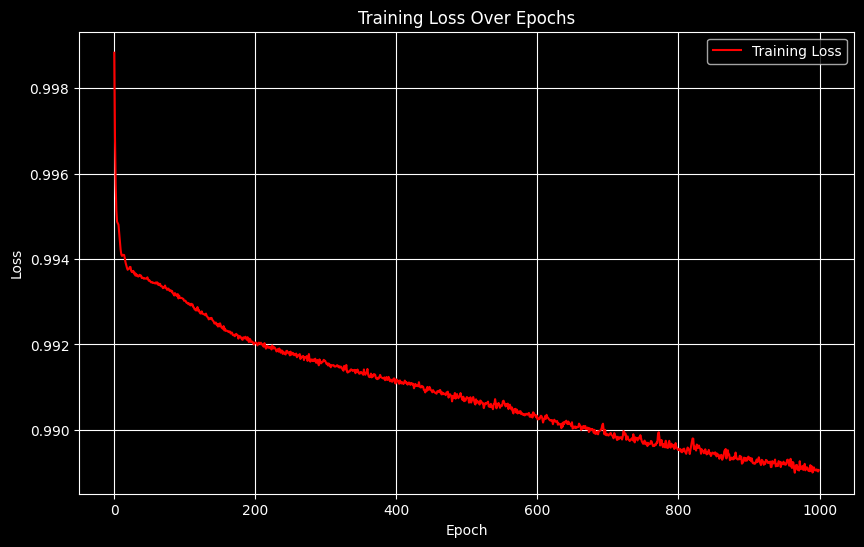

In [49]:
# Get the loss values from the history object
loss_values = history.history['loss']

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### 

### Back testing

In [50]:
MLP_factor_df = price_test[date_stock] # Date and stock
MLP_factor_df.loc[:, 'Factor_values'] = y_pred_MLP_test # Add factor values
MLP_factor_df = MLP_factor_df.pivot(index='trade_date', 
                      columns='ts_code', 
                      values='Factor_values') # Transfer to factor dataframe
MLP_factor_df

ts_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,601919.SH,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,601999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,-0.035353,0.015821,0.055996,0.037271,0.039166,-0.089611,0.057499,0.062953,0.000072,-0.203393,...,-0.037765,0.027912,-0.039296,-0.044988,-0.016184,-0.011952,0.009085,0.032342,-0.030244,0.043674
2023-06-28,-0.062828,-0.045386,-0.005101,0.035023,0.053113,-0.008808,0.064029,0.104578,0.015332,-0.024101,...,-0.073734,0.024412,-0.093247,-0.025941,-0.067303,-0.071068,-0.055979,0.040362,-0.031109,0.053981
2023-06-29,-0.088206,-0.140961,-0.626586,0.047947,0.043404,-0.091256,0.086409,0.113867,0.029514,-0.018247,...,-0.101440,0.029591,-0.124461,-0.044535,-0.096165,-0.103680,-0.092051,0.046977,-0.067650,0.034048
2023-06-30,-0.083381,-0.120904,0.043796,0.056988,0.047300,-0.043140,0.068716,0.120357,0.045776,0.008327,...,-0.054096,0.038143,-0.119591,-0.020103,-0.091350,-0.103071,-0.073967,0.052826,-0.110789,0.063904
2023-07-03,-0.042981,-0.098678,0.062462,0.043498,0.054381,-0.105800,0.065176,0.083519,0.016617,0.035254,...,-0.071489,0.049853,-0.060889,-0.048642,-0.042929,-0.046400,-0.026688,0.030986,-0.035903,0.070025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,-0.064099,-0.019565,0.003506,-0.095928,-0.025958,-0.186597,-0.078805,-0.022174,-0.027115,-0.147791,...,-0.046035,-0.045071,-0.104529,-0.038669,-0.101959,-0.090131,-0.069837,-0.048372,-0.100685,0.021620
2024-01-26,-0.032360,0.020777,-0.176843,-0.002650,0.036925,-0.224828,-0.019236,-0.064839,0.005778,-0.339762,...,-0.017737,-0.004091,-0.053016,-0.008472,-0.022626,-0.031183,-0.014044,0.004470,-0.053820,0.015732
2024-01-29,-0.013161,0.006295,-0.110728,0.019094,0.007367,-0.040675,-0.003731,-0.116844,-0.024196,-0.184942,...,-0.008907,-0.031811,-0.067209,-0.044355,-0.034215,-0.041426,-0.004010,0.017118,-0.027368,0.067439


In [51]:
path = 'D:\\AI_data_analysis\\CY\\'
MLP_factor_df.to_csv(path + 'MLP_factor_df.csv')

In [89]:
a = [1, 2, 3, 4, 5]
b = [2, 3, 4, 5, 6]
c = [7, 6, 3, 1, 10]

a = pd.Series(a)
b = pd.Series(b)
c = pd.Series(c)

print(a.corr(c, method='spearman'))
print(a.corr(c, method='pearson'))

0.0
0.045083481733371615


In [80]:
MLP_factor_df

ts_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,601919.SH,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,601999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,-0.035353,0.015821,0.055996,0.037271,0.039166,-0.089611,0.057499,0.062953,0.000072,-0.203393,...,-0.037765,0.027912,-0.039296,-0.044988,-0.016184,-0.011952,0.009085,0.032342,-0.030244,0.043674
2023-06-28,-0.062828,-0.045386,-0.005101,0.035023,0.053113,-0.008808,0.064029,0.104578,0.015332,-0.024101,...,-0.073734,0.024412,-0.093247,-0.025941,-0.067303,-0.071068,-0.055979,0.040362,-0.031109,0.053981
2023-06-29,-0.088206,-0.140961,-0.626586,0.047947,0.043404,-0.091256,0.086409,0.113867,0.029514,-0.018247,...,-0.101440,0.029591,-0.124461,-0.044535,-0.096165,-0.103680,-0.092051,0.046977,-0.067650,0.034048
2023-06-30,-0.083381,-0.120904,0.043796,0.056988,0.047300,-0.043140,0.068716,0.120357,0.045776,0.008327,...,-0.054096,0.038143,-0.119591,-0.020103,-0.091350,-0.103071,-0.073967,0.052826,-0.110789,0.063904
2023-07-03,-0.042981,-0.098678,0.062462,0.043498,0.054381,-0.105800,0.065176,0.083519,0.016617,0.035254,...,-0.071489,0.049853,-0.060889,-0.048642,-0.042929,-0.046400,-0.026688,0.030986,-0.035903,0.070025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,-0.064099,-0.019565,0.003506,-0.095928,-0.025958,-0.186597,-0.078805,-0.022174,-0.027115,-0.147791,...,-0.046035,-0.045071,-0.104529,-0.038669,-0.101959,-0.090131,-0.069837,-0.048372,-0.100685,0.021620
2024-01-26,-0.032360,0.020777,-0.176843,-0.002650,0.036925,-0.224828,-0.019236,-0.064839,0.005778,-0.339762,...,-0.017737,-0.004091,-0.053016,-0.008472,-0.022626,-0.031183,-0.014044,0.004470,-0.053820,0.015732
2024-01-29,-0.013161,0.006295,-0.110728,0.019094,0.007367,-0.040675,-0.003731,-0.116844,-0.024196,-0.184942,...,-0.008907,-0.031811,-0.067209,-0.044355,-0.034215,-0.041426,-0.004010,0.017118,-0.027368,0.067439


In [52]:
# layer number
num_layers = 20

# Calculte the ranks of factors daily.
factor_ranks = MLP_factor_df.rank(axis=1, ascending=False)

# The factor ordering is divided into num_layers, each of which allocates funds equally.
layer_allocation = (factor_ranks // (len(MLP_factor_df.columns) / num_layers)).fillna(0)
layer_allocation

ts_code,000001.SZ,000002.SZ,000004.SZ,000006.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,000012.SZ,000014.SZ,...,601919.SH,601933.SH,601939.SH,601958.SH,601988.SH,601989.SH,601991.SH,601992.SH,601998.SH,601999.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,15.0,9.0,4.0,6.0,6.0,18.0,3.0,3.0,10.0,19.0,...,15.0,7.0,16.0,16.0,13.0,13.0,9.0,7.0,15.0,5.0
2023-06-28,15.0,14.0,11.0,7.0,4.0,11.0,3.0,1.0,9.0,12.0,...,17.0,8.0,18.0,13.0,16.0,16.0,15.0,6.0,13.0,4.0
2023-06-29,16.0,18.0,19.0,6.0,6.0,16.0,2.0,1.0,8.0,12.0,...,16.0,8.0,17.0,14.0,16.0,16.0,16.0,6.0,15.0,7.0
2023-06-30,16.0,18.0,6.0,4.0,6.0,15.0,3.0,0.0,6.0,11.0,...,15.0,7.0,17.0,13.0,16.0,17.0,16.0,5.0,17.0,3.0
2023-07-03,15.0,18.0,3.0,6.0,4.0,18.0,2.0,1.0,9.0,7.0,...,18.0,4.0,17.0,16.0,15.0,16.0,13.0,7.0,14.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,14.0,10.0,8.0,17.0,10.0,19.0,15.0,10.0,10.0,18.0,...,12.0,12.0,17.0,12.0,17.0,16.0,15.0,13.0,17.0,6.0
2024-01-26,15.0,8.0,19.0,11.0,6.0,19.0,13.0,17.0,10.0,19.0,...,13.0,11.0,17.0,12.0,14.0,15.0,13.0,10.0,17.0,8.0
2024-01-29,11.0,9.0,18.0,7.0,8.0,15.0,10.0,18.0,13.0,19.0,...,11.0,14.0,17.0,15.0,14.0,15.0,10.0,7.0,13.0,1.0


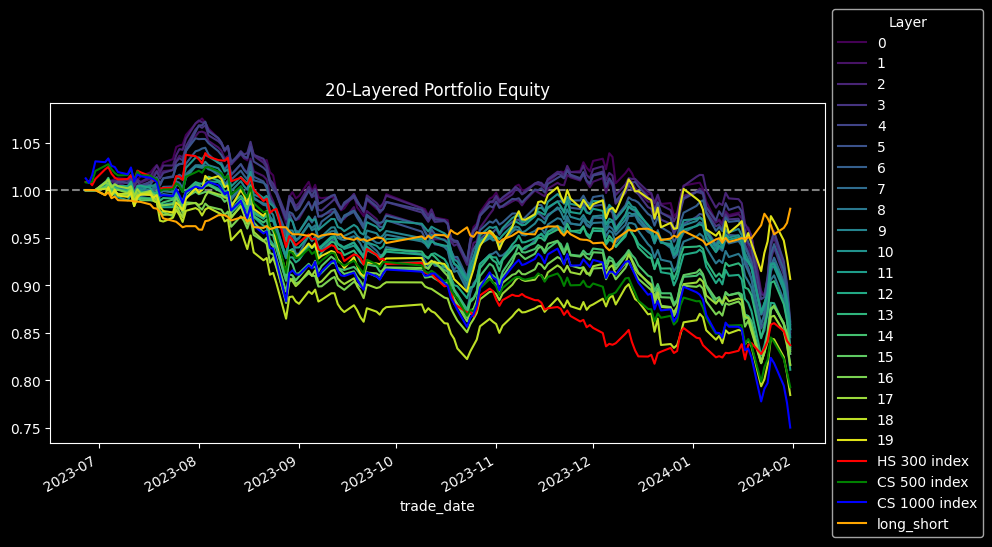

In [53]:
# import matplotlib.cm as cm

plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
plt.figure(figsize=(10, 5))
plt.axhline(y=1, color='grey', linestyle='--')

# Define a color map to use for changing colors progressively
# colors = plt.cm.jet(np.linspace(0, 1, num_layers))

def Ensure_position(DF):
    # We add a column named 'Monday' and change positions every Monday.
    DF = DF.shift(1) # Move one step forward to ensure position
    DF["Monday"] = (DF.index.dayofweek == 0).astype(int) # Shift except Monday

    # Get the columns to shift (all columns except 'Monday')
    cols_to_shift = DF.columns[DF.columns != 'Monday']

    DF.loc[DF['Monday'] == 0, cols_to_shift] = np.nan
    DF.fillna(method='ffill', inplace=True) # Forward fill, holing positions for a week.
    DF.fillna(value=0, inplace=True) # Fill remaining NaN with 0
    return DF

profit_long = None
profit_short = None
def Long_Short(Num_layers, Layer, Profit):
    global profit_long, profit_short
    if Layer == 0:
        profit_short = Profit
        # The short profit comes from the decline of the stock.
        profit_short = profit_short.apply(lambda x: x + 1 if x == 0 else -x + (1 - 0.0003))
        profit_short = profit_short.cumprod()
        profit_short *= 0.5
    elif Layer == Num_layers - 1:
        profit_long = Profit
        profit_long = profit_long.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_long = profit_long.cumprod()
        profit_long *= 0.5

Long_position_df = None
for layer in range(0, num_layers):
    # Ensure holding stocks
    hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(layer_allocation == layer, 1)
    hold_flag_matrix = Ensure_position(hold_flag_matrix)
    if layer == num_layers - 1:
        Long_position_df = hold_flag_matrix

    # Delete 'Monday' to fit into yield dataframe.
    del hold_flag_matrix["Monday"]

    # Calculate the sum of each line in turn.
    stock_amount_sum = hold_flag_matrix.sum(axis=1)

    # Calculate the weight of each stock. (Average distribution at the same level)
    weight_allocation = hold_flag_matrix.apply(lambda x: x / stock_amount_sum, axis=0).fillna(0)

    # Calculate the daily profit rate. And prepare to calculate cumprod.
    profit = (weight_allocation * price_return_test).sum(axis=1)

    # Create Long and Short position
    Long_Short(num_layers, layer, profit)

    # Calculate the daily equity and draw.
    # Using the 'viridis' colormap with a gradient based on layer number
    colors = cm.viridis(layer / num_layers)
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label=layer, legend=True, color=colors)

profit_HS300 = HS_300_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color='r')
profit_CS500 = CS_500_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color='g')
profit_CS1000 = CS_1000_test.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color='b')

(profit_long + profit_short).plot(color='orange', label='long_short', legend=True)
plt.title("20-Layered Portfolio Equity")
plt.legend(title='Layer', bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

### Indexes

1. RankIC mean(IC mean)
2. ICIR
3. IC winning rate
4. IC t-value
5. Long ROI
6. Long sharp
7. Long retracement
8. Long average weekly turnover rate

IC mean: -0.07444649876463917
ICIR: -0.5061937667020454


<Axes: >

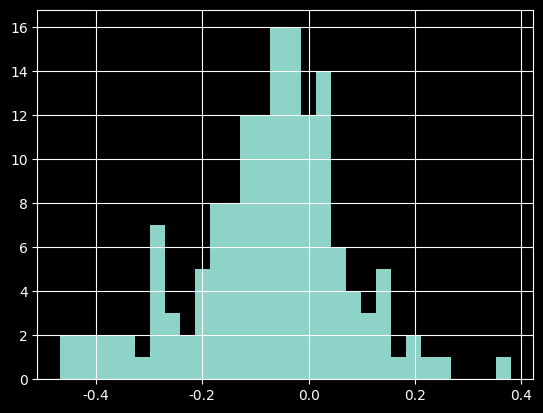

In [54]:
# ICIR
IC_series = MLP_factor_df.corrwith(price_return_test, 
                                   axis=1,
                                   method='spearman')
IC_mean = IC_series.mean()
print(f'IC mean: {IC_mean}')
ICIR = IC_series.mean() / IC_series.std()
print(f"ICIR: {ICIR}")
IC_series.hist(bins=30)

In [55]:
# IC winning rate
IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
print(f"IC winning rate: {IC_winning_rate}")

IC winning rate: 0.29333333333333333


In [56]:
t_value = ICIR / sqrt(len(IC_series))
print(f"IC t-value: {t_value}")

IC t-value: -0.04133054797991471


In [57]:
# Long (Except Short), so `profit_long * 2`
# profit_long is long equity series.
Long_equity = profit_long * 2
Long_ROI = (Long_equity[-1]) - 1
print(f"Long ROI: {Long_ROI}")

# Max Drawdown
# Calculate the previous peaks
previous_peaks = Long_equity.cummax()
# Calculate the drawdowns
drawdowns = (Long_equity - previous_peaks) / previous_peaks

# Find the maximum drawdown and the dates associated with it
# Convert the index labels to a numeric format
drawdowns.index = pd.to_numeric(drawdowns.index)
max_drawdown = drawdowns.min()
print(f'Max drawdown: {max_drawdown}')
max_drawdown_start = drawdowns.idxmin()

# Convert the start and end dates back to the original format if needed
max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
print(f"Max drawdown begin date: {max_drawdown_start}")

Long ROI: -0.09354879544999972
Max drawdown: -0.12006738888351844
Max drawdown begin date: 2023-10-23
